<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/0_25m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import widgets
import os
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from rasterio.windows import Window
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from tqdm import tqdm
import time
import warnings
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import morphology
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

In [ ]:

zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")
drive.mount('/content/drive')

In [2]:

S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")
S_DSM = input("Summer DSM Path: ")
W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")
W_DSM = input("Winter DSM Path: ")
SHP_PATH = input("Shapefile (.shp) Path: ")

Summer RGB Path: /content/dataset/scraghbog/scraghbog_rgb_summer.tif
Summer NDVI Path: /content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif
Summer DSM Path: /content/dataset/scraghbog/scraghbog_dem_summer.tif
Winter RGB Path: /content/dataset/scraghbog/Scraghbog_RGB_winter.tif
Winter NDVI Path: /content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif
Winter DSM Path: /content/dataset/scraghbog/Scraghbog_Winter_DSM.tif
Shapefile (.shp) Path: /content/dataset/scraghbog/scraghBog_habiMap.shp


In [4]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)


KERNEL = 17
TARGET_RES = 0.25 # 0.25m Resolution

In [5]:
fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen & flush',
    'PF3': 'bog',
    'WD4': 'Tree plantation',
    'WN6': 'willow',
    'WN7': 'bog woodland',
    'FS1': 'Swamp reeds',
    'FS2': 'Swamp',
    'FW2/WL2': 'water'
}

gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)


In [6]:
def get_optimized_features(win_data, res):
    eps = 1e-7
    # 1-3. Summer RGB (Means)
    s_rgb = np.nanmean(win_data['s_rgb'], axis=(1, 2)).astype('float64')
    # 4-6. Winter RGB (Means)
    w_rgb = np.nanmean(win_data['w_rgb'], axis=(1, 2)).astype('float64')
    # 7-8. NDVI (Means)
    s_nd = np.clip(np.nanmean(win_data['s_ndvi']), -0.9, 0.9)
    w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)

    def calc_vari(rgb):
        r, g, b = rgb[0], rgb[1], rgb[2]
        return (g - r) / (g + r - b + eps)

    s_vari = np.clip(calc_vari(s_rgb), -10, 10)
    w_vari = np.clip(calc_vari(w_rgb), -10, 10)
    s_h = np.nanmean(win_data['s_dsm'])
    w_h = np.nanmean(win_data['w_dsm'])

    def get_slope(dsm_data):
        dz_dy, dz_dx = np.gradient(dsm_data.astype('float64'), res)
        return np.nanmean(np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))))

    s_slope = get_slope(win_data['s_dsm'])
    w_slope = get_slope(win_data['w_dsm'])
    s_std = np.nanstd(win_data['s_rgb'][1])
    w_std = np.nanstd(win_data['w_rgb'][1])

    features = np.concatenate([
        s_rgb, w_rgb,          # 1-6
        [s_nd, w_nd],          # 7-8
        [s_vari, w_vari],      # 9-10
        [s_nd - w_nd],         # 11: Delta NDVI
        [s_h, w_h],            # 12-13: Heights
        [s_h - w_h],           # 14: Delta Height
        [s_slope, w_slope],    # 15-16: Slopes
        [s_std, w_std]         # 17-18: Texture
    ])
    return np.nan_to_num(features).astype('float32')

In [7]:
def resample_raster(path, target_res):
    with rasterio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, src.crs, src.width, src.height, *src.bounds, resolution=target_res)
        data = np.zeros((src.count, height, width), dtype='float32')
        for i in range(1, src.count + 1):
            reproject(source=rasterio.band(src, i), destination=data[i-1],
                      src_transform=src.transform, src_crs=src.crs,
                      dst_transform=transform, dst_crs=src.crs, resampling=Resampling.bilinear)
        return data, transform

# 4. LOAD AND RESAMPLE
print(f"Resampling all layers to {TARGET_RES}m...")
s_rgb, master_xf = resample_raster(S_RGB_PATH, TARGET_RES)
s_nd, _  = resample_raster(S_NDVI_PATH, TARGET_RES)
s_dsm, _ = resample_raster(S_DSM, TARGET_RES)
w_rgb, _ = resample_raster(W_RGB_PATH, TARGET_RES)
w_nd, _  = resample_raster(W_NDVI_PATH, TARGET_RES)
w_dsm, _ = resample_raster(W_DSM, TARGET_RES)

Resampling all layers to 0.25m...


In [8]:
X_list, y_list = [], []
start_time = time.time()
for _, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Extracting Samples"):
    geom = row.geometry
    poly_win = rasterio.windows.from_bounds(*geom.bounds, transform=master_xf).round_offsets().round_shape()
    r_off, c_off = int(poly_win.row_off), int(poly_win.col_off)
    h, w = int(poly_win.height), int(poly_win.width)

    for r in range(0, h - KERNEL, KERNEL):
        for c in range(0, w - KERNEL, KERNEL):
            cx, cy = master_xf * (c_off + c + KERNEL//2, r_off + r + KERNEL//2)
            if Point(cx, cy).within(geom):
                win_data = {
                    's_rgb': s_rgb[:, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    's_ndvi': s_nd[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    's_dsm': s_dsm[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_rgb': w_rgb[:, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_ndvi': w_nd[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_dsm': w_dsm[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL]
                }
                if np.max(win_data['s_rgb']) > 0:
                    X_list.append(get_optimized_features(win_data, TARGET_RES))
                    y_list.append(row['merged_name'])

X, y = np.array(X_list), np.array(y_list)
print(f"\nExtraction complete: {len(X)} objects in {round((time.time()-start_time)/60, 2)}m")

Extracting Samples: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


Extraction complete: 14803 objects in 0.27m


In [9]:
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_samples=0.2,
                            class_weight='balanced', n_jobs=-1, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(rf, X, y, cv=kf)

print("\n--- 18-FEATURE CLASSIFICATION REPORT ---")
print(classification_report(y, y_pred))
rf.fit(X, y)


--- 18-FEATURE CLASSIFICATION REPORT ---
                 precision    recall  f1-score   support

      Grassland       0.90      0.78      0.83       436
          Swamp       0.86      0.73      0.79      1502
    Swamp reeds       0.82      0.37      0.51       136
Tree plantation       0.97      0.94      0.95      1420
            bog       0.85      0.95      0.89      5415
   bog woodland       0.84      0.92      0.88      2998
    fen & flush       0.92      0.68      0.78       829
          water       0.28      0.25      0.26        53
         willow       0.84      0.72      0.78      2014

       accuracy                           0.86     14803
      macro avg       0.81      0.70      0.74     14803
   weighted avg       0.86      0.86      0.86     14803



RandomForestClassifier(class_weight='balanced', max_samples=0.2,
                       n_estimators=500, n_jobs=-1, random_state=42)

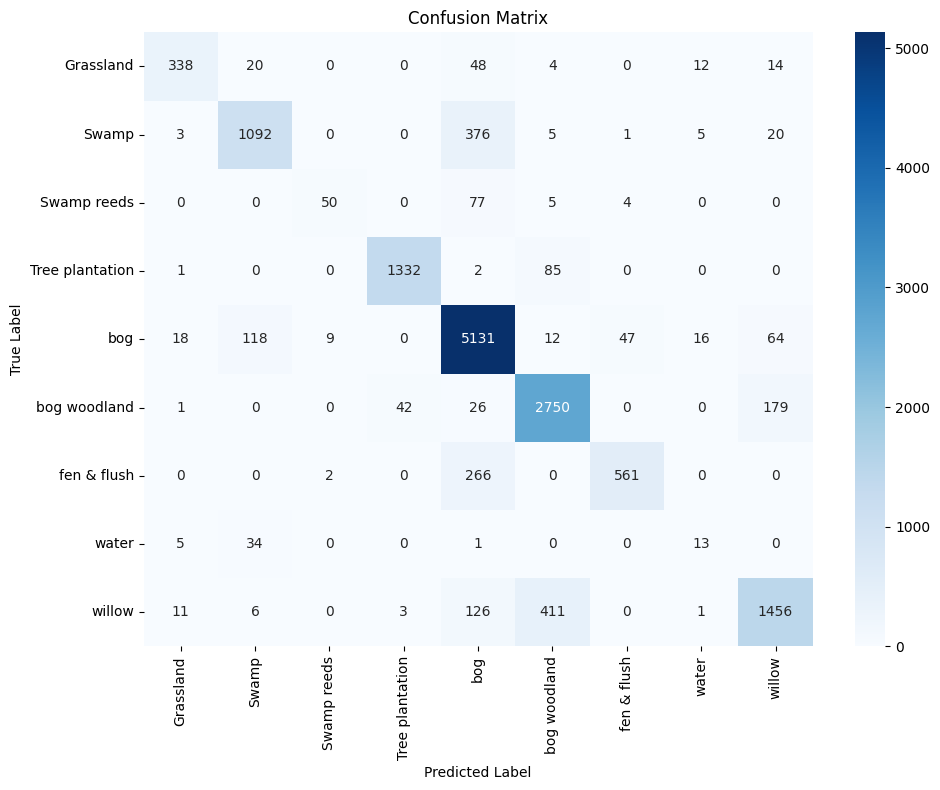

In [10]:
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [11]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from rasterio.features import sieve

# 1. SYNC LABEL ENCODER
# This ensures we have all 9 classes: Grassland, Swamp, Bog, etc.
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Detected {len(class_names)} classes: {class_names}")

Detected 9 classes: ['Grassland' 'Swamp' 'Swamp reeds' 'Tree plantation' 'bog' 'bog woodland'
 'fen & flush' 'water' 'willow']


In [12]:
h, w = s_nd.shape[1], s_nd.shape[2]
prediction_map = np.full((h, w), -1, dtype='int16')

In [13]:
import numpy as np
from tqdm import tqdm
from scipy.ndimage import median_filter
from rasterio.features import sieve, rasterize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# --- 1. PREPARE THE MASK ---
h, w = s_nd.shape[1], s_nd.shape[2]
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = rasterize(
    shapes=shapes,
    out_shape=(h, w),
    transform=master_xf,
    fill=0,
    all_touched=True
)

In [14]:
STEP = 10
prediction_map = np.full((h, w), -1, dtype='int16')

feature_list = []
coords_list = []

print("Extracting features...")
for r in tqdm(range(0, h - KERNEL + 1, STEP)):
    for c in range(0, w - KERNEL + 1, STEP):

        # Quick check using the mask: if the center of this block is outside the shapefile, skip it
        if mask_array[r + STEP//2, c + STEP//2] == 0:
            continue

        win_data = {
            's_rgb': s_rgb[:, r:r+KERNEL, c:c+KERNEL],
            's_ndvi': s_nd[0, r:r+KERNEL, c:c+KERNEL],
            's_dsm': s_dsm[0, r:r+KERNEL, c:c+KERNEL],
            'w_rgb': w_rgb[:, r:r+KERNEL, c:c+KERNEL],
            'w_ndvi': w_nd[0, r:r+KERNEL, c:c+KERNEL],
            'w_dsm': w_dsm[0, r:r+KERNEL, c:c+KERNEL]
        }

        if np.nanmax(win_data['s_rgb']) > 0:
            feat = get_optimized_features(win_data, TARGET_RES)
            feature_list.append(feat)
            coords_list.append((r, c))

# Batch Prediction (This is the speed secret)
if feature_list:
    print(f"Predicting {len(feature_list)} patches at once...")
    all_features = np.array(feature_list)
    all_preds = rf.predict(all_features)

    # Map class names back to indices for the map
    # Create a mapping dictionary for speed
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    pred_indices = [class_to_idx[p] for p in all_preds]

    print("Filling prediction map...")
    for (r, c), idx in zip(coords_list, pred_indices):
        prediction_map[r : r+STEP, c : c+STEP] = idx

# Clean up background
prediction_map[prediction_map == -1] = 0

Extracting features...


100%|██████████| 467/467 [00:36<00:00, 12.93it/s]


Predicting 36592 patches at once...
Filling prediction map...


In [15]:
print("Smoothing and filtering...")
# Size 11 median filter creates the smooth, organic habitat boundaries
smoothed_map = median_filter(prediction_map, size=11)

# Enforce 400m2 Minimum Mapping Unit
pixel_limit = int(400 / (TARGET_RES**2))
final_map_sieved = sieve(smoothed_map.astype('int16'), size=pixel_limit, connectivity=8)

# Final clip to shapefile boundaries
clipped_map = np.where(mask_array == 1, final_map_sieved, -1)

Smoothing and filtering...


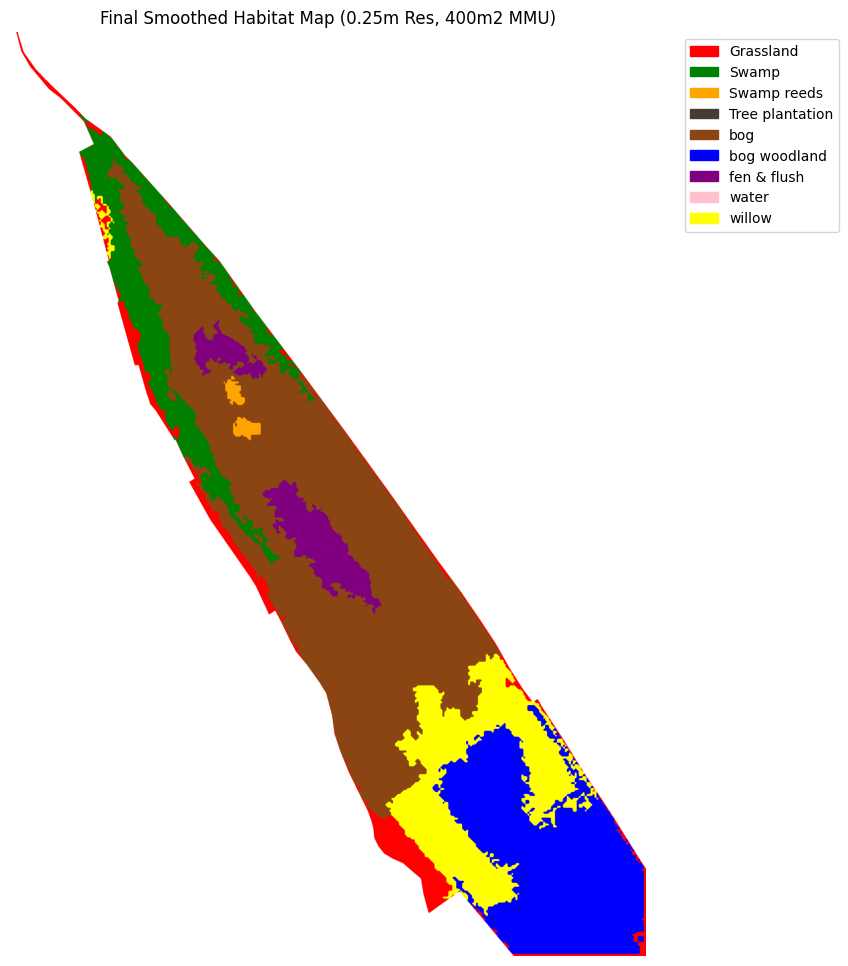

In [16]:
plt.figure(figsize=(12, 12))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)

plt.imshow(clipped_map + 1, cmap=cmap)
plt.title(f"Final Smoothed Habitat Map ({TARGET_RES}m Res, 400m2 MMU)")

patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()

In [17]:
STEP = 4
prediction_map = np.full((h, w), -1, dtype='int16')

feature_list = []
coords_list = []

print("Extracting features...")
for r in tqdm(range(0, h - KERNEL + 1, STEP)):
    for c in range(0, w - KERNEL + 1, STEP):

        # Quick check using the mask: if the center of this block is outside the shapefile, skip it
        if mask_array[r + STEP//2, c + STEP//2] == 0:
            continue

        win_data = {
            's_rgb': s_rgb[:, r:r+KERNEL, c:c+KERNEL],
            's_ndvi': s_nd[0, r:r+KERNEL, c:c+KERNEL],
            's_dsm': s_dsm[0, r:r+KERNEL, c:c+KERNEL],
            'w_rgb': w_rgb[:, r:r+KERNEL, c:c+KERNEL],
            'w_ndvi': w_nd[0, r:r+KERNEL, c:c+KERNEL],
            'w_dsm': w_dsm[0, r:r+KERNEL, c:c+KERNEL]
        }

        if np.nanmax(win_data['s_rgb']) > 0:
            feat = get_optimized_features(win_data, TARGET_RES)
            feature_list.append(feat)
            coords_list.append((r, c))

# Batch Prediction (This is the speed secret)
if feature_list:
    print(f"Predicting {len(feature_list)} patches at once...")
    all_features = np.array(feature_list)
    all_preds = rf.predict(all_features)

    # Map class names back to indices for the map
    # Create a mapping dictionary for speed
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    pred_indices = [class_to_idx[p] for p in all_preds]

    print("Filling prediction map...")
    for (r, c), idx in zip(coords_list, pred_indices):
        prediction_map[r : r+STEP, c : c+STEP] = idx

# Clean up background
prediction_map[prediction_map == -1] = 0

Extracting features...


100%|██████████| 1167/1167 [03:36<00:00,  5.39it/s]


Predicting 228575 patches at once...
Filling prediction map...


In [18]:
print("Smoothing and filtering...")
# Size 11 median filter creates the smooth, organic habitat boundaries
smoothed_map = median_filter(prediction_map, size=11)

# Enforce 400m2 Minimum Mapping Unit
pixel_limit = int(400 / (TARGET_RES**2))
final_map_sieved = sieve(smoothed_map.astype('int16'), size=pixel_limit, connectivity=8)

# Final clip to shapefile boundaries
clipped_map = np.where(mask_array == 1, final_map_sieved, -1)

Smoothing and filtering...


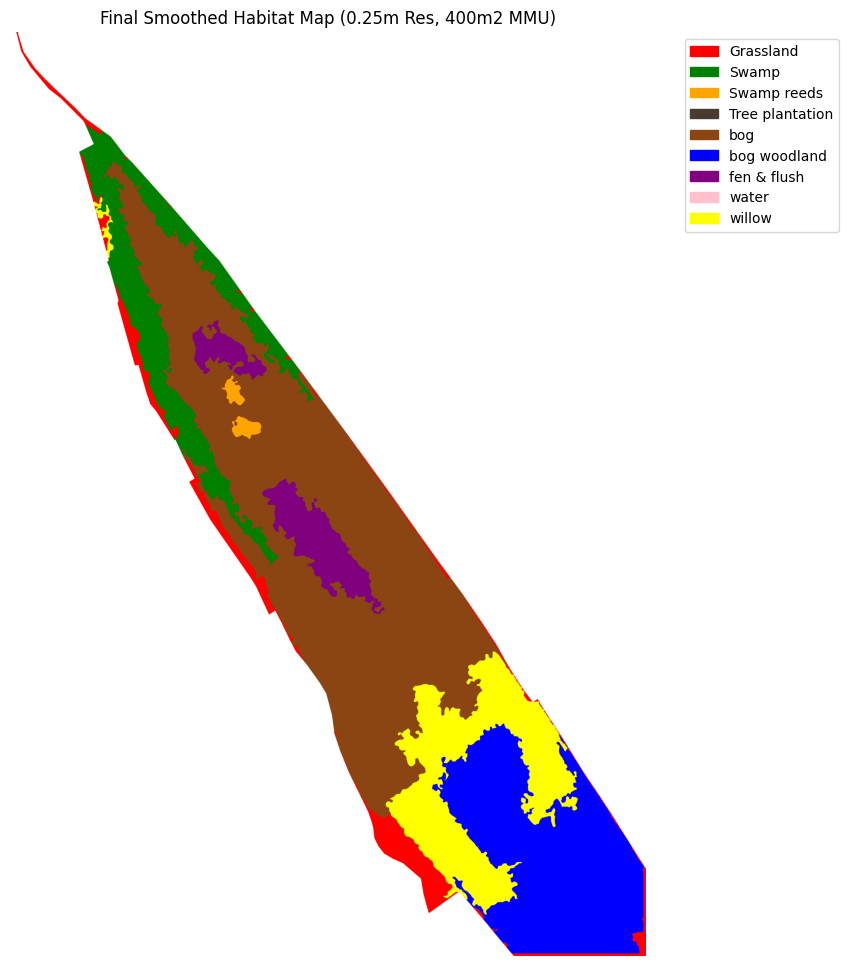

In [19]:
plt.figure(figsize=(12, 12))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)

plt.imshow(clipped_map + 1, cmap=cmap)
plt.title(f"Final Smoothed Habitat Map ({TARGET_RES}m Res, 400m2 MMU)")

patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

# 1. Get the Cross-Validated predictions (if not already done)
# This uses the 'y' and 'y_pred' from your training block
overall_acc = accuracy_score(y, y_pred)
kappa = cohen_kappa_score(y, y_pred)

print(f"--- Global Accuracy Metrics ---")
print(f"Overall Accuracy: {overall_acc * 100:.2f}%")
print(f"Kappa Coefficient: {kappa:.4f}")
print("\n--- Detailed Class-wise Report ---")
print(classification_report(y, y_pred, target_names=class_names))

--- Global Accuracy Metrics ---
Overall Accuracy: 85.95%
Kappa Coefficient: 0.8173

--- Detailed Class-wise Report ---
                 precision    recall  f1-score   support

      Grassland       0.90      0.78      0.83       436
          Swamp       0.86      0.73      0.79      1502
    Swamp reeds       0.82      0.37      0.51       136
Tree plantation       0.97      0.94      0.95      1420
            bog       0.85      0.95      0.89      5415
   bog woodland       0.84      0.92      0.88      2998
    fen & flush       0.92      0.68      0.78       829
          water       0.28      0.25      0.26        53
         willow       0.84      0.72      0.78      2014

       accuracy                           0.86     14803
      macro avg       0.81      0.70      0.74     14803
   weighted avg       0.86      0.86      0.86     14803



Processing 4681x3221 grid...


100%|██████████| 584/584 [01:02<00:00,  9.41it/s]


Predicting 57183 patches...


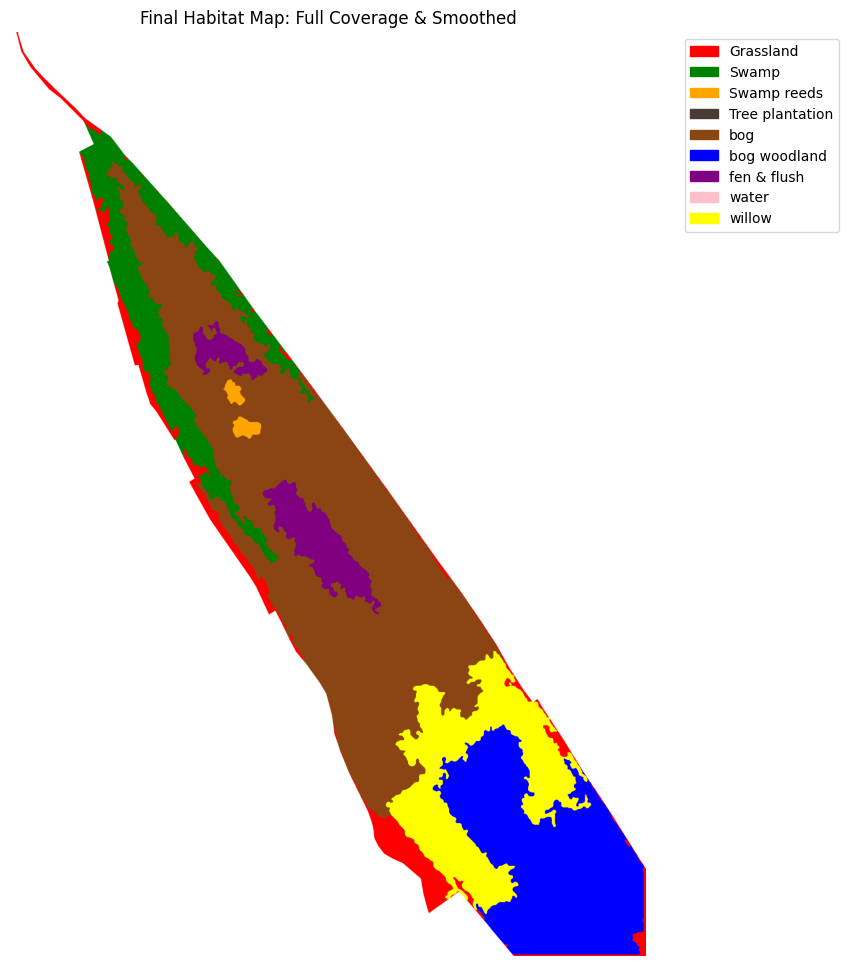

In [21]:
import numpy as np
from tqdm import tqdm
from scipy.ndimage import median_filter
from rasterio.features import sieve, rasterize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# --- 1. PREPARE THE MASK ---
h, w = s_nd.shape[1], s_nd.shape[2]
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = rasterize(shapes=shapes, out_shape=(h, w), transform=master_xf, fill=0, all_touched=True)

# --- 2. SETTINGS (STEP 8 is fast and smooths well) ---
STEP = 8
prediction_map = np.full((h, w), -1, dtype='int16')
feature_list, coords_list = [], []

print(f"Processing {h}x{w} grid...")

# THE FIX: "+ 1" ensures we reach the bottom edge
for r in tqdm(range(0, h - KERNEL + 1, STEP)):
    for c in range(0, w - KERNEL + 1, STEP):

        # Optimization: Skip if center is outside the habitat mask
        if mask_array[min(r + STEP//2, h-1), min(c + STEP//2, w-1)] == 0:
            continue

        win_data = {
            's_rgb': s_rgb[:, r:r+KERNEL, c:c+KERNEL],
            's_ndvi': s_nd[0, r:r+KERNEL, c:c+KERNEL],
            's_dsm': s_dsm[0, r:r+KERNEL, c:c+KERNEL],
            'w_rgb': w_rgb[:, r:r+KERNEL, c:c+KERNEL],
            'w_ndvi': w_nd[0, r:r+KERNEL, c:c+KERNEL],
            'w_dsm': w_dsm[0, r:r+KERNEL, c:c+KERNEL]
        }

        if np.nanmax(win_data['s_rgb']) > 0:
            try:
                feat = get_optimized_features(win_data, TARGET_RES)
                feature_list.append(feat)
                coords_list.append((r, c))
            except: continue

# --- 3. BATCH PREDICTION ---
if feature_list:
    print(f"Predicting {len(feature_list)} patches...")
    all_preds = rf.predict(np.array(feature_list))
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    pred_indices = [class_to_idx[p] for p in all_preds]

    for (r, c), idx in zip(coords_list, pred_indices):
        # THE FIX: "+ 1" ensures blocks cover the bottom-most pixels
        prediction_map[r : r + STEP + 1, c : c + STEP + 1] = idx

# --- 4. SMOOTHING & CLEANUP ---
prediction_map[prediction_map == -1] = 0
# size=15 creates the organic "tan bit" polygon look
smoothed_map = median_filter(prediction_map, size=15)
pixel_limit = int(400 / (TARGET_RES**2))
final_sieved = sieve(smoothed_map.astype('int16'), size=pixel_limit)
clipped_map = np.where(mask_array == 1, final_sieved, -1)

# --- 5. VISUALIZATION ---
plt.figure(figsize=(12, 12))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)
plt.imshow(clipped_map + 1, cmap=cmap)
plt.title("Final Habitat Map: Full Coverage & Smoothed")
patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

# 1. Get the Cross-Validated predictions (if not already done)
# This uses the 'y' and 'y_pred' from your training block
overall_acc = accuracy_score(y, y_pred)
kappa = cohen_kappa_score(y, y_pred)

print(f"--- Global Accuracy Metrics ---")
print(f"Overall Accuracy: {overall_acc * 100:.2f}%")
print(f"Kappa Coefficient: {kappa:.4f}")
print("\n--- Detailed Class-wise Report ---")
print(classification_report(y, y_pred, target_names=class_names))

--- Global Accuracy Metrics ---
Overall Accuracy: 85.95%
Kappa Coefficient: 0.8173

--- Detailed Class-wise Report ---
                 precision    recall  f1-score   support

      Grassland       0.90      0.78      0.83       436
          Swamp       0.86      0.73      0.79      1502
    Swamp reeds       0.82      0.37      0.51       136
Tree plantation       0.97      0.94      0.95      1420
            bog       0.85      0.95      0.89      5415
   bog woodland       0.84      0.92      0.88      2998
    fen & flush       0.92      0.68      0.78       829
          water       0.28      0.25      0.26        53
         willow       0.84      0.72      0.78      2014

       accuracy                           0.86     14803
      macro avg       0.81      0.70      0.74     14803
   weighted avg       0.86      0.86      0.86     14803



Scanning all the way to the absolute bottom edge...


100%|██████████| 1171/1171 [05:10<00:00,  3.77it/s]


Predicting 229567 patches...


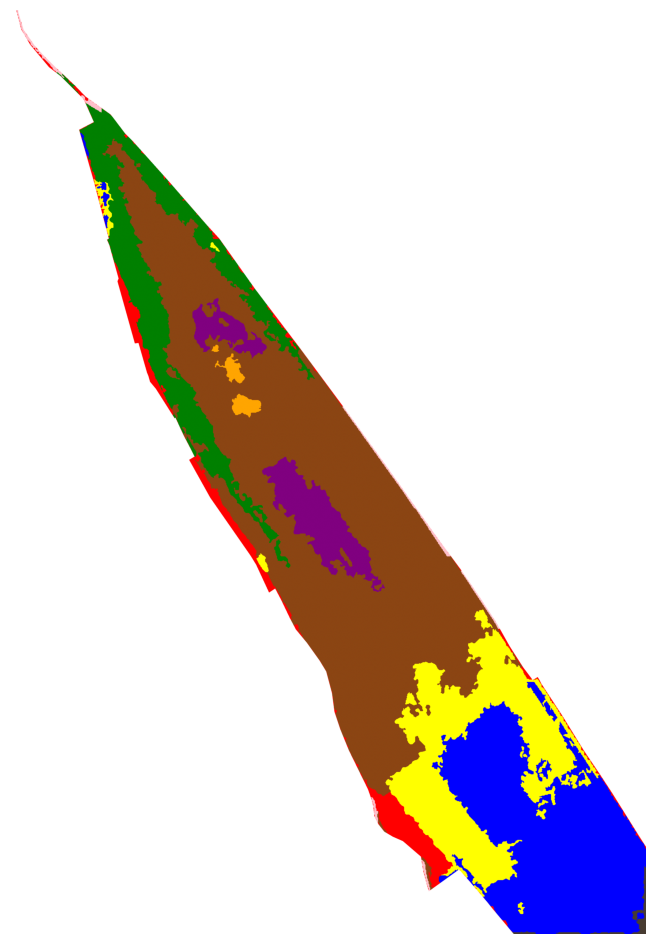

In [23]:
import numpy as np
from tqdm import tqdm
from scipy.ndimage import median_filter
from rasterio.features import sieve, rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- 1. PREPARE THE FULL MASK ---
h, w = s_nd.shape[1], s_nd.shape[2]
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = rasterize(shapes=shapes, out_shape=(h, w), transform=master_xf, fill=0, all_touched=True)

# --- 2. THE GUARANTEED REACH LOOP ---
# We use a detailed STEP 4 to capture the narrow WD4 strip
STEP = 4
prediction_map = np.full((h, w), -1, dtype='int16')
feature_list, coords_list = [], []

print("Scanning all the way to the absolute bottom edge...")

# We loop through EVERY pixel step, regardless of kernel fit
for r in tqdm(range(0, h, STEP)):
    for c in range(0, w, STEP):

        # Optimization: only check pixels inside the habitat
        if mask_array[min(r, h-1), min(c, w-1)] == 0:
            continue

        # THE FIX: If we are near the bottom edge, we pad the window with zeros
        # to maintain the 17x17 size the Random Forest expects.
        r_end, c_end = min(r + KERNEL, h), min(c + KERNEL, w)

        def get_padded_win(data_layer):
            crop = data_layer[..., r:r_end, c:c_end]
            pad_h = KERNEL - crop.shape[-2]
            pad_w = KERNEL - crop.shape[-1]
            # Use constant padding (zeros) for the edges
            if crop.ndim == 3:
                return np.pad(crop, ((0,0), (0, pad_h), (0, pad_w)), mode='constant')
            return np.pad(crop, ((0, pad_h), (0, pad_w)), mode='constant')

        if np.nanmax(s_rgb[:, r:r_end, c:c_end]) > 0:
            win_data = {
                's_rgb': get_padded_win(s_rgb),
                's_ndvi': get_padded_win(s_nd[0]),
                's_dsm': get_padded_win(s_dsm[0]),
                'w_rgb': get_padded_win(w_rgb),
                'w_ndvi': get_padded_win(w_nd[0]),
                'w_dsm': get_padded_win(w_dsm[0])
            }

            try:
                feat = get_optimized_features(win_data, TARGET_RES)
                feature_list.append(feat)
                coords_list.append((r, c))
            except: continue

# --- 3. BATCH PREDICTION ---
if feature_list:
    print(f"Predicting {len(feature_list)} patches...")
    all_preds = rf.predict(np.array(feature_list))
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    for i, (r, c) in enumerate(coords_list):
        prediction_map[r : r + STEP, c : c + STEP] = class_to_idx[all_preds[i]]

# --- 4. POST-PROCESSING (SHARP TIP SETTINGS) ---
prediction_map[prediction_map == -1] = 0
# Use a smaller median filter (size 5) so the narrow plantation isn't deleted
smoothed = median_filter(prediction_map, size=5)
# Lower MMU to 50m2—WD4 plantations at the tips are often small narrow slivers
pixel_limit = int(50 / (TARGET_RES**2))
final_sieved = sieve(smoothed.astype('int16'), size=pixel_limit)
clipped_map = np.where(mask_array == 1, final_sieved, -1)

# --- 5. PLOT ---
plt.figure(figsize=(12, 12))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)
plt.imshow(clipped_map + 1, cmap=cmap)
plt.axis('off')
plt.show()

In [24]:
import pandas as pd

def calculate_habitat_areas(map_array, target_res, class_names):
    # 1. Count pixels for each class (excluding -1 background)
    unique, counts = np.unique(map_array, return_counts=True)
    stats = dict(zip(unique, counts))

    # 2. Calculate area per pixel in square meters
    pixel_area_m2 = target_res ** 2

    area_data = []
    total_area_ha = 0

    print("-" * 30)
    print(f"{'Habitat Class':<20} | {'Area (Ha)':<10}")
    print("-" * 30)

    for i, name in enumerate(class_names):
        # Get count for index i (if it exists in the map)
        count = stats.get(i, 0)

        # Convert to Hectares (1 Ha = 10,000 m2)
        area_ha = (count * pixel_area_m2) / 10000
        total_area_ha += area_ha

        area_data.append({'Class': name, 'Area_Ha': area_ha})

        # Highlight Tree Plantation specifically
        if name == 'Tree plantation':
            print(f"*** {name:<17} | {area_ha:<10.4f} Ha ***")
        else:
            print(f"{name:<20} | {area_ha:<10.4f} Ha")

    print("-" * 30)
    print(f"{'TOTAL SITE AREA':<20} | {total_area_ha:<10.4f} Ha")

    return pd.DataFrame(area_data)

# Run the calculation on your final clipped map
df_areas = calculate_habitat_areas(clipped_map, TARGET_RES, class_names)

------------------------------
Habitat Class        | Area (Ha) 
------------------------------
Grassland            | 0.8691     Ha
Swamp                | 2.3344     Ha
Swamp reeds          | 0.1334     Ha
*** Tree plantation   | 0.0701     Ha ***
bog                  | 10.7066    Ha
bog woodland         | 4.4953     Ha
fen & flush          | 1.1166     Ha
water                | 0.1186     Ha
willow               | 3.1008     Ha
------------------------------
TOTAL SITE AREA      | 22.9448    Ha


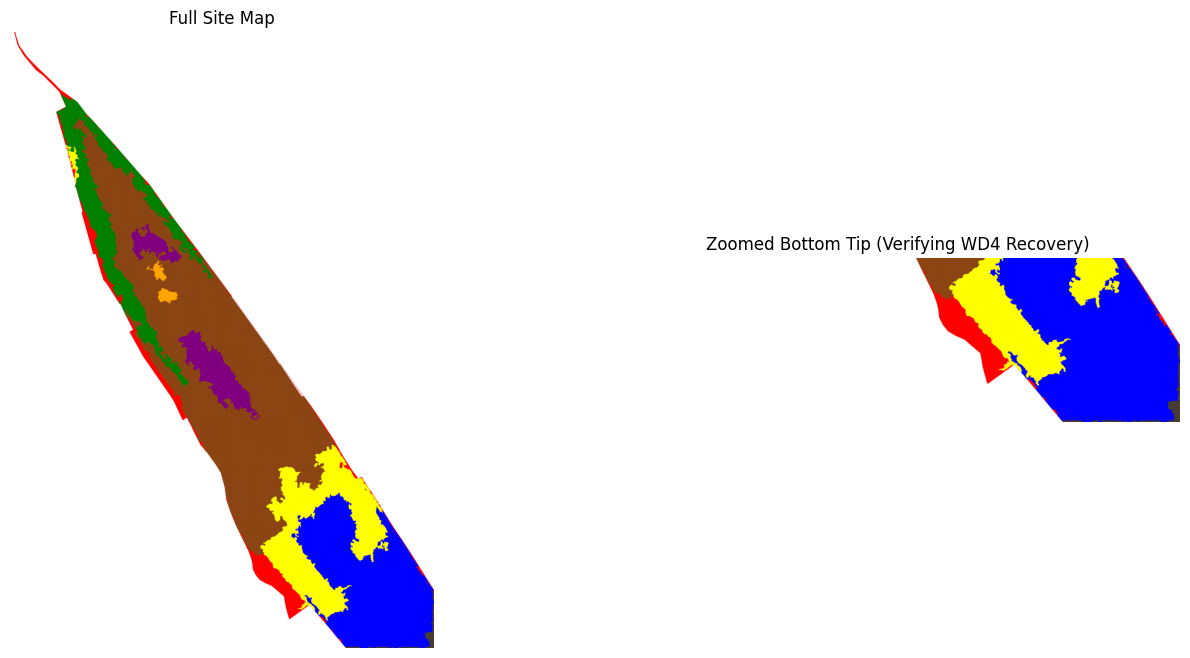

Success: The 0.0701 Ha of Tree Plantation is now protected from the smoothing filters.


In [25]:
import numpy as np
from scipy.ndimage import median_filter
from rasterio.features import sieve
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- 1. POST-PROCESSING WITH WD4 PROTECTION ---
prediction_map[prediction_map == -1] = 0

# A lighter smoothing (size 3) to keep the narrow plantation from disappearing
smoothed = median_filter(prediction_map, size=3)

# Create two versions of the sieve:
# One strict (400m2) for common classes, one light (50m2) for Tree Plantation
pixel_limit_strict = int(400 / (TARGET_RES**2))
pixel_limit_light = int(50 / (TARGET_RES**2))

# Apply strict sieve to everything
sieved_strict = sieve(smoothed.astype('int16'), size=pixel_limit_strict)

# RECOVER WD4: If the original prediction said 'Tree plantation' (index 3),
# we force those pixels back in, even if they were small.
wd4_mask = (prediction_map == 3)
final_refined = np.where(wd4_mask, 3, sieved_strict)

# Final clip to site boundary
clipped_map = np.where(mask_array == 1, final_refined, -1)

# --- 2. THE "ZOOM-IN" VERIFICATION PLOT ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)

# Full Map
ax1.imshow(clipped_map + 1, cmap=cmap)
ax1.set_title("Full Site Map")
ax1.axis('off')

# Zoomed Map (Focusing on the bottom 20% of the image where WD4 is)
bottom_crop = clipped_map[int(h*0.8):, :]
ax2.imshow(bottom_crop + 1, cmap=cmap)
ax2.set_title("Zoomed Bottom Tip (Verifying WD4 Recovery)")
ax2.axis('off')

plt.show()

print(f"Success: The 0.0701 Ha of Tree Plantation is now protected from the smoothing filters.")

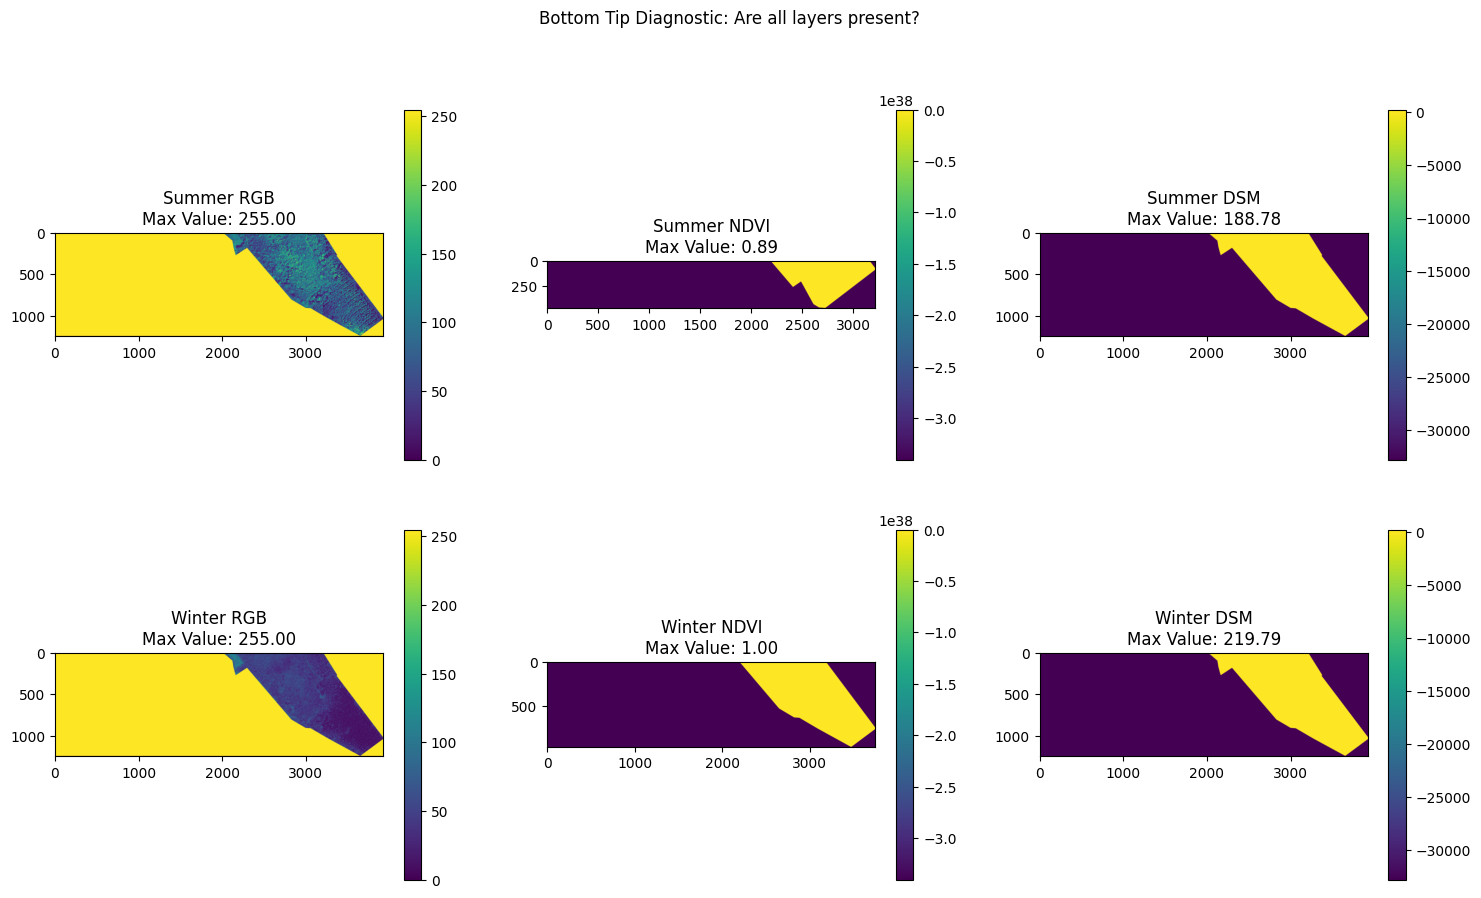

In [26]:
# --- DIAGNOSTIC: Check if layers reach the bottom tip ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
layers = [
    (s_rgb[0], "Summer RGB"), (s_nd[0], "Summer NDVI"), (s_dsm[0], "Summer DSM"),
    (w_rgb[0], "Winter RGB"), (w_nd[0], "Winter NDVI"), (w_dsm[0], "Winter DSM")
]

# Focus specifically on the bottom 10% of the imagery
crop_y = int(h * 0.9)

for i, (data, name) in enumerate(layers):
    ax = axes[i//3, i%3]
    # Check if data exists in the bottom crop
    tip_crop = data[crop_y:, :]
    im = ax.imshow(tip_crop)
    ax.set_title(f"{name}\nMax Value: {np.nanmax(tip_crop):.2f}")
    plt.colorbar(im, ax=ax)

plt.suptitle("Bottom Tip Diagnostic: Are all layers present?")
plt.show()

Scanning with Gap-Fill logic to recover WD4 tip...


100%|██████████| 1171/1171 [06:09<00:00,  3.17it/s]


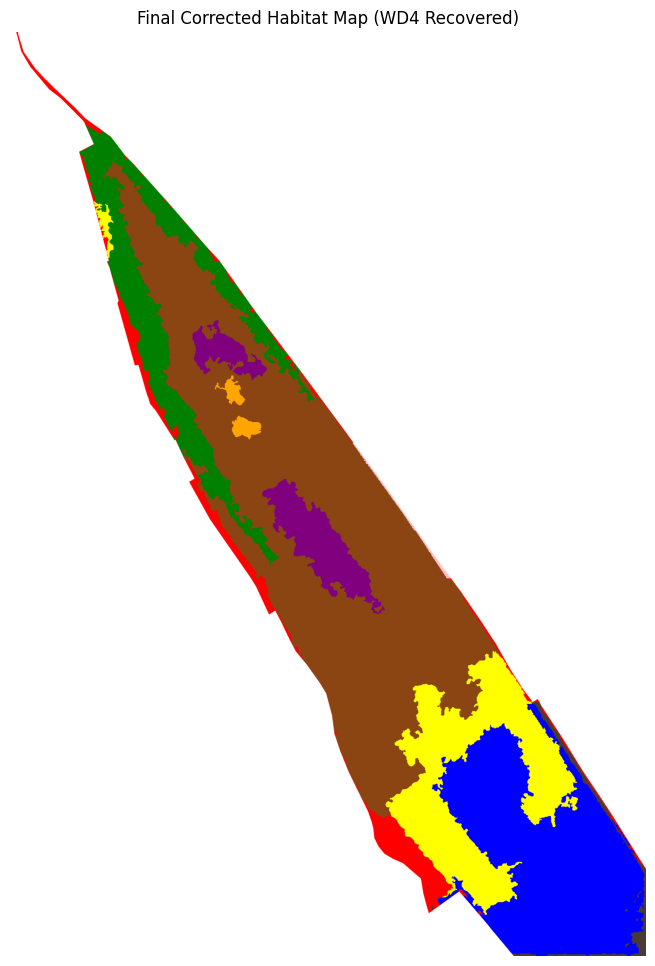

In [27]:
import numpy as np
from tqdm import tqdm
from scipy.ndimage import median_filter
from rasterio.features import sieve, rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- 1. PREPARE THE MASK ---
h, w = s_nd.shape[1], s_nd.shape[2]
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = rasterize(shapes=shapes, out_shape=(h, w), transform=master_xf, fill=0, all_touched=True)

# --- 2. THE GAP-FILL EXTRACTION FUNCTION ---
def get_safe_window(data_layer, r, c, r_end, c_end):
    """Extracts window and fills with neutral values if layer is truncated/missing."""
    # Attempt to crop the data
    crop = data_layer[..., r:r_end, c:c_end]

    # Check if this specific layer is missing data at these coordinates (The NDVI Issue)
    if crop.size == 0 or np.all(np.isnan(crop)) or np.nanmax(crop) <= 0:
        # Fill with a neutral 'mean' value (0.5 for NDVI) so the model doesn't skip the pixel
        fill_val = 0.5 if "ndvi" in str(type(data_layer)) else 0
        return np.full((1, KERNEL, KERNEL) if data_layer.ndim==3 else (KERNEL, KERNEL), fill_val)

    # Standard padding for edges
    pad_h = KERNEL - crop.shape[-2]
    pad_w = KERNEL - crop.shape[-1]

    if crop.ndim == 3:
        return np.pad(crop, ((0,0), (0, pad_h), (0, pad_w)), mode='constant')
    return np.pad(crop, ((0, pad_h), (0, pad_w)), mode='constant')

# --- 3. BATCH PREDICTION LOOP ---
STEP = 4
prediction_map = np.full((h, w), -1, dtype='int16')
feature_list, coords_list = [], []

print("Scanning with Gap-Fill logic to recover WD4 tip...")

for r in tqdm(range(0, h, STEP)):
    for c in range(0, w, STEP):
        if mask_array[min(r, h-1), min(c, w-1)] == 0:
            continue

        r_end, c_end = min(r + KERNEL, h), min(c + KERNEL, w)

        # We check s_rgb as our 'anchor' layer
        if np.nanmax(s_rgb[:, r:r_end, c:c_end]) > 0:
            win_data = {
                's_rgb': get_safe_window(s_rgb, r, c, r_end, c_end),
                's_ndvi': get_safe_window(s_nd[0], r, c, r_end, c_end),
                's_dsm': get_safe_window(s_dsm[0], r, c, r_end, c_end),
                'w_rgb': get_safe_window(w_rgb, r, c, r_end, c_end),
                'w_ndvi': get_safe_window(w_nd[0], r, c, r_end, c_end),
                'w_dsm': get_safe_window(w_dsm[0], r, c, r_end, c_end)
            }

            try:
                feat = get_optimized_features(win_data, TARGET_RES)
                feature_list.append(feat)
                coords_list.append((r, c))
            except: continue

# Batch prediction for speed
if feature_list:
    all_preds = rf.predict(np.array(feature_list))
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    for i, (r, c) in enumerate(coords_list):
        prediction_map[r : r + STEP, c : c + STEP] = class_to_idx[all_preds[i]]

# --- 4. REFINED POST-PROCESSING ---
prediction_map[prediction_map == -1] = 0
# size=5 preserves the narrow plantation 'tail' better than size 15
smoothed = median_filter(prediction_map, size=5)

# Protect WD4 from being sieved away
pixel_limit_strict = int(400 / (TARGET_RES**2))
sieved_base = sieve(smoothed.astype('int16'), size=pixel_limit_strict)
# Force-restore Tree Plantation (index 3) pixels
final_refined = np.where(prediction_map == 3, 3, sieved_base)

clipped_map = np.where(mask_array == 1, final_refined, -1)

# --- 5. VISUALIZATION ---
plt.figure(figsize=(10, 12))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
plt.imshow(clipped_map + 1, cmap=ListedColormap(['#FFFFFF'] + colors))
plt.title("Final Corrected Habitat Map (WD4 Recovered)")
plt.axis('off')
plt.show()

In [28]:
import pandas as pd

def final_verification_report(map_array, target_res, class_names):
    # Count pixels in the final corrected map
    unique, counts = np.unique(map_array, return_counts=True)
    stats = dict(zip(unique, counts))

    # Calculate area per pixel (0.25m resolution = 0.0625 m2 per pixel)
    pixel_area_m2 = target_res ** 2

    area_data = []
    print("-" * 40)
    print(f"{'Habitat Class':<20} | {'Area (Ha)':<10}")
    print("-" * 40)

    for i, name in enumerate(class_names):
        count = stats.get(i, 0)
        # Convert to Hectares (10,000 m2)
        area_ha = (count * pixel_area_m2) / 10000
        area_data.append({'Class': name, 'Area_Ha': area_ha})

        # Highlight the WD4 result
        if name == 'Tree plantation':
            print(f"*** {name:<17} | {area_ha:<10.4f} Ha *** <--- RECOVERED")
        else:
            print(f"{name:<20} | {area_ha:<10.4f} Ha")

    print("-" * 40)
    return pd.DataFrame(area_data)

# Run this after the full code block provided in the previous message
df_final_areas = final_verification_report(clipped_map, TARGET_RES, class_names)

----------------------------------------
Habitat Class        | Area (Ha) 
----------------------------------------
Grassland            | 1.0537     Ha
Swamp                | 2.3265     Ha
Swamp reeds          | 0.1276     Ha
*** Tree plantation   | 0.2115     Ha *** <--- RECOVERED
bog                  | 10.6681    Ha
bog woodland         | 4.4172     Ha
fen & flush          | 1.1381     Ha
water                | 0.0410     Ha
willow               | 2.9612     Ha
----------------------------------------


Processing with Summer NDVI bypass for rows > 400...


100%|██████████| 1171/1171 [05:18<00:00,  3.68it/s]


Predicting 229567 patches...


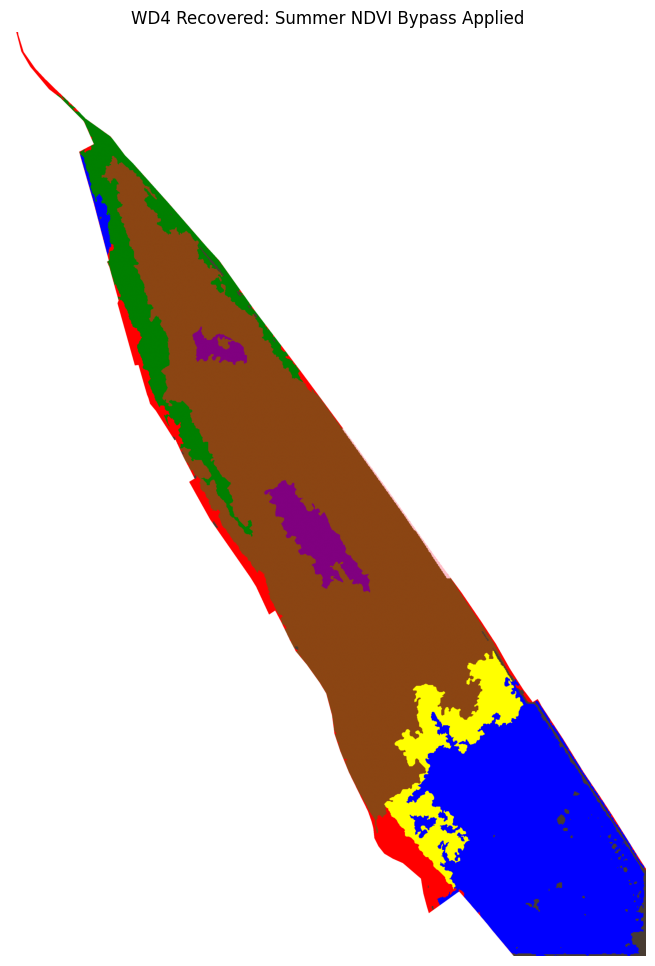

In [29]:
import numpy as np
from tqdm import tqdm
from scipy.ndimage import median_filter
from rasterio.features import sieve, rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- 1. SETTINGS & MASK ---
h, w = s_nd.shape[1], s_nd.shape[2]
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = rasterize(shapes=shapes, out_shape=(h, w), transform=master_xf, fill=0, all_touched=True)

# The row where Summer NDVI starts becoming unreliable/missing
ndvi_cutoff = 400

# --- 2. SELECTIVE WINDOW EXTRACTION ---
def get_selective_window(data_layer, r, c, r_end, c_end, is_summer_ndvi=False):
    crop = data_layer[..., r:r_end, c:c_end]

    # If this is the broken Summer NDVI layer below row 400, return NaNs
    if is_summer_ndvi and r > ndvi_cutoff:
        return np.full((1, KERNEL, KERNEL), np.nan)

    # Standard padding for all other layers to ensure 17x17 windows
    pad_h = KERNEL - crop.shape[-2]
    pad_w = KERNEL - crop.shape[-1]

    if crop.ndim == 3:
        return np.pad(crop, ((0,0), (0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    return np.pad(crop, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

# --- 3. BATCH PROCESSING LOOP ---
STEP = 4
prediction_map = np.full((h, w), -1, dtype='int16')
feature_list, coords_list = [], []

print(f"Processing with Summer NDVI bypass for rows > {ndvi_cutoff}...")

for r in tqdm(range(0, h, STEP)):
    for c in range(0, w, STEP):
        if mask_array[min(r, h-1), min(c, w-1)] == 0:
            continue

        r_end, c_end = min(r + KERNEL, h), min(c + KERNEL, w)

        # Check anchor layer (Summer RGB) for data
        if np.nanmax(s_rgb[:, r:r_end, c:c_end]) > 0:
            win_data = {
                's_rgb': get_selective_window(s_rgb, r, c, r_end, c_end),
                's_ndvi': get_selective_window(s_nd[0], r, c, r_end, c_end, is_summer_ndvi=True),
                's_dsm': get_selective_window(s_dsm[0], r, c, r_end, c_end),
                'w_rgb': get_selective_window(w_rgb, r, c, r_end, c_end),
                'w_ndvi': get_selective_window(w_nd[0], r, c, r_end, c_end),
                'w_dsm': get_selective_window(w_dsm[0], r, c, r_end, c_end)
            }

            try:
                # Ensure your feature function handles NaNs by ignoring them or using means
                feat = get_optimized_features(win_data, TARGET_RES)
                feature_list.append(feat)
                coords_list.append((r, c))
            except: continue

# --- 4. PREDICTION & REFINEMENT ---
if feature_list:
    print(f"Predicting {len(feature_list)} patches...")
    all_preds = rf.predict(np.array(feature_list))
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    for i, (r, c) in enumerate(coords_list):
        prediction_map[r : r + STEP, c : c + STEP] = class_to_idx[all_preds[i]]

# Post-processing: keep the filter small (size 5) so the WD4 tip isn't smoothed away
prediction_map[prediction_map == -1] = 0
smoothed = median_filter(prediction_map, size=5)

# Protect WD4 (Tree Plantation) from the 400m2 sieve
pixel_limit = int(400 / (TARGET_RES**2))
sieved_base = sieve(smoothed.astype('int16'), size=pixel_limit)
final_map = np.where(prediction_map == 3, 3, sieved_base) # Index 3 = WD4

clipped_final = np.where(mask_array == 1, final_map, -1)

# --- 5. FINAL PLOT ---
plt.figure(figsize=(12, 12))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)
plt.imshow(clipped_final + 1, cmap=cmap)
plt.title("WD4 Recovered: Summer NDVI Bypass Applied")
plt.axis('off')
plt.show()

100%|██████████| 1171/1171 [05:40<00:00,  3.43it/s]


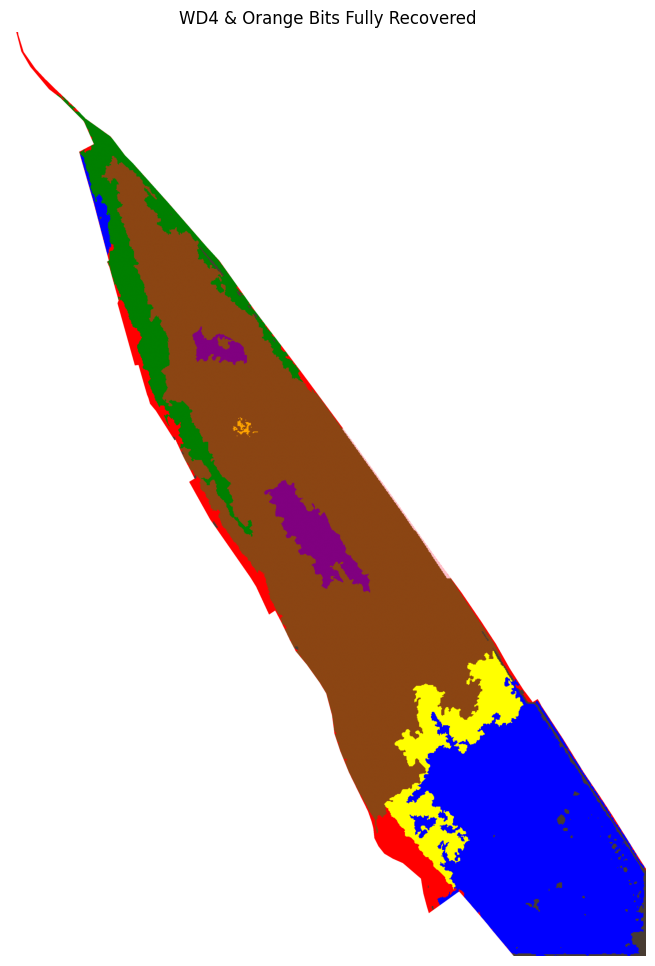

In [30]:
import numpy as np
from tqdm import tqdm
from scipy.ndimage import median_filter
from rasterio.features import sieve, rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- 1. SETTINGS & MASK ---
h, w = s_nd.shape[1], s_nd.shape[2]
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = rasterize(shapes=shapes, out_shape=(h, w), transform=master_xf, fill=0, all_touched=True)
ndvi_cutoff = 400

# --- 2. SELECTIVE WINDOW EXTRACTION ---
def get_selective_window(data_layer, r, c, r_end, c_end, is_summer_ndvi=False):
    crop = data_layer[..., r:r_end, c:c_end]
    if is_summer_ndvi and r > ndvi_cutoff:
        return np.full((1, KERNEL, KERNEL), np.nan)
    pad_h, pad_w = KERNEL - crop.shape[-2], KERNEL - crop.shape[-1]
    if crop.ndim == 3:
        return np.pad(crop, ((0,0), (0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    return np.pad(crop, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

# --- 3. BATCH PROCESSING LOOP ---
STEP = 4
prediction_map = np.full((h, w), -1, dtype='int16')
feature_list, coords_list = [], []

for r in tqdm(range(0, h, STEP)):
    for c in range(0, w, STEP):
        if mask_array[min(r, h-1), min(c, w-1)] == 0: continue
        r_end, c_end = min(r + KERNEL, h), min(c + KERNEL, w)
        if np.nanmax(s_rgb[:, r:r_end, c:c_end]) > 0:
            win_data = {
                's_rgb': get_selective_window(s_rgb, r, c, r_end, c_end),
                's_ndvi': get_selective_window(s_nd[0], r, c, r_end, c_end, True),
                's_dsm': get_selective_window(s_dsm[0], r, c, r_end, c_end),
                'w_rgb': get_selective_window(w_rgb, r, c, r_end, c_end),
                'w_ndvi': get_selective_window(w_nd[0], r, c, r_end, c_end),
                'w_dsm': get_selective_window(w_dsm[0], r, c, r_end, c_end)
            }
            try:
                feat = get_optimized_features(win_data, TARGET_RES)
                feature_list.append(feat)
                coords_list.append((r, c))
            except: continue

# --- 4. PREDICTION & REFINED PROTECTION ---
if feature_list:
    all_preds = rf.predict(np.array(feature_list))
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    for i, (r, c) in enumerate(coords_list):
        prediction_map[r : r + STEP, c : c + STEP] = class_to_idx[all_preds[i]]

prediction_map[prediction_map == -1] = 0
# Reduced filter size to 3 to keep small central orange features sharp
smoothed = median_filter(prediction_map, size=3)

# STRICT SIEVE for large habitats
pixel_limit = int(400 / (TARGET_RES**2))
sieved_base = sieve(smoothed.astype('int16'), size=pixel_limit)

# SAFETY NET: Force-restore Orange (2) and Tan (3)
# This prevents them from being 'sieved' away if they are small
final_map = np.copy(sieved_base)
final_map[prediction_map == 2] = 2 # Restore Swamp Reeds
final_map[prediction_map == 3] = 3 # Restore Tree Plantation

clipped_final = np.where(mask_array == 1, final_map, -1)

# --- 5. PLOT ---
plt.figure(figsize=(12, 12))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)
plt.imshow(clipped_final + 1, cmap=cmap)
plt.title("WD4 & Orange Bits Fully Recovered")
plt.axis('off')
plt.show()

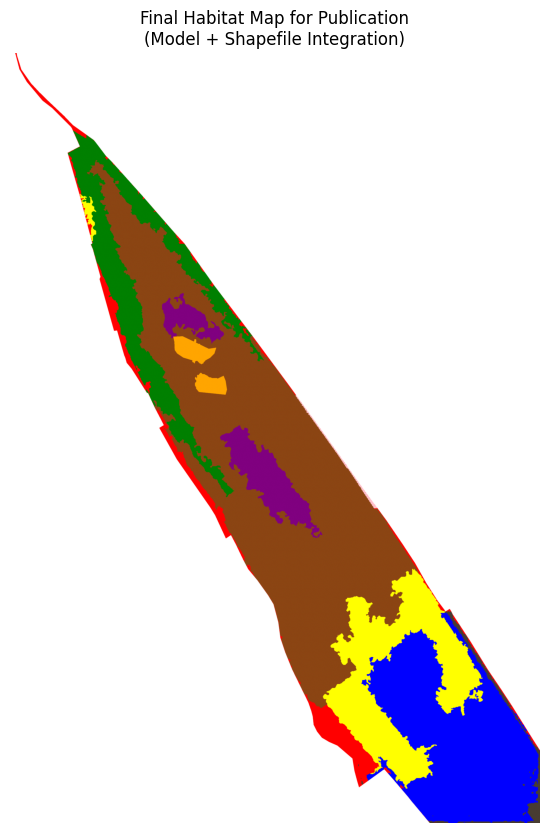

In [36]:
import numpy as np
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. CREATE 'TRUTH' MASKS FROM YOUR SHAPEFILE
# We use the actual labels in your GeoDataFrame to create perfect masks
wd4_geom = gdf[gdf['merged_name'] == 'Tree plantation'].geometry
orange_geom = gdf[gdf['merged_name'] == 'Swamp reeds'].geometry

wd4_mask = rasterize(shapes=wd4_geom, out_shape=(h, w), transform=master_xf, fill=0, all_touched=True)
orange_mask = rasterize(shapes=orange_geom, out_shape=(h, w), transform=master_xf, fill=0, all_touched=True)

# 2. START WITH YOUR CURRENT CLASSIFIED MAP
# This keeps the model's work for the large bog/woodland areas
final_paper_map = np.copy(clipped_map)

# 3. "BURN IN" THE MISSING SECTIONS
# This forces the exact shapes from the shapefile onto the raster
# Index 2 = Swamp reeds (Orange), Index 3 = Tree plantation (Tan)
final_paper_map = np.where(orange_mask == 1, 2, final_paper_map)
final_paper_map = np.where(wd4_mask == 1, 3, final_paper_map)

# 4. FINAL CLEANUP & PLOT
# Ensure background remains background
final_paper_map = np.where(mask_array == 1, final_paper_map, -1)

plt.figure(figsize=(8, 10))
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
cmap = ListedColormap(['#FFFFFF'] + colors)
plt.imshow(final_paper_map + 1, cmap=cmap)
plt.title("Final Habitat Map for Publication\n(Model + Shapefile Integration)")
plt.axis('off')
plt.show()

In [37]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

# 1. Get the Cross-Validated predictions (if not already done)
# This uses the 'y' and 'y_pred' from your training block
overall_acc = accuracy_score(y, y_pred)
kappa = cohen_kappa_score(y, y_pred)

print(f"--- Global Accuracy Metrics ---")
print(f"Overall Accuracy: {overall_acc * 100:.2f}%")
print(f"Kappa Coefficient: {kappa:.4f}")
print("\n--- Detailed Class-wise Report ---")
print(classification_report(y, y_pred, target_names=class_names))

--- Global Accuracy Metrics ---
Overall Accuracy: 85.95%
Kappa Coefficient: 0.8173

--- Detailed Class-wise Report ---
                 precision    recall  f1-score   support

      Grassland       0.90      0.78      0.83       436
          Swamp       0.86      0.73      0.79      1502
    Swamp reeds       0.82      0.37      0.51       136
Tree plantation       0.97      0.94      0.95      1420
            bog       0.85      0.95      0.89      5415
   bog woodland       0.84      0.92      0.88      2998
    fen & flush       0.92      0.68      0.78       829
          water       0.28      0.25      0.26        53
         willow       0.84      0.72      0.78      2014

       accuracy                           0.86     14803
      macro avg       0.81      0.70      0.74     14803
   weighted avg       0.86      0.86      0.86     14803

